# Wstępny trening sieci do rozpoznawania znaków w captchy

Co będziemy tutaj robić:

- Zaimportujemy biblioteki
- Wczytamy dane
- Sprawdzimy czy dane wczytały się poprawnie
- Zbudujemy model
- Skompilujemy model
- Przeuczymy sieć

In [ ]:
# import tensorflow as tf
from keras.models import Sequential, Model
import keras.metrics
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.optimizers import SGD, Adam
from keras.preprocessing.image import img_to_array, load_img, array_to_img
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import string
%matplotlib inline

In [2]:
def load_data(path):
    data = []
    chars = ''.join(sorted(string.ascii_letters + string.digits)) 
    for c in chars:
        for i in range(250):
            if c not in string.ascii_lowercase:
                image = load_img(path + c + str(i) + ".jpg")
            else:
                image = load_img(path + 'z' + c + str(i) + ".jpg")
            arr = img_to_array(image)
            data.append(arr)
    labels = pd.read_csv(path + "labels.csv")
    return np.true_divide(np.array(data), 255), labels

In [3]:
data, labels = load_data("../data/chars/")
print(labels.head())
data.shape

   Unnamed: 0  0  1  2  3  4  5  6  7  8  ...  q  r  s  t  u  v  w  x  y  z
0           0  1  0  0  0  0  0  0  0  0  ...  0  0  0  0  0  0  0  0  0  0
1           1  1  0  0  0  0  0  0  0  0  ...  0  0  0  0  0  0  0  0  0  0
2           2  1  0  0  0  0  0  0  0  0  ...  0  0  0  0  0  0  0  0  0  0
3           3  1  0  0  0  0  0  0  0  0  ...  0  0  0  0  0  0  0  0  0  0
4           4  1  0  0  0  0  0  0  0  0  ...  0  0  0  0  0  0  0  0  0  0

[5 rows x 63 columns]


(15500, 60, 60, 3)

### Tutaj trochę ustawień

In [4]:
INPUT_SHAPE = data[1,:,:,:].shape
CLASS_NUM = len(''.join(sorted(string.ascii_letters + string.digits)) )
print(CLASS_NUM)
INPUT_SHAPE

62


(60, 60, 3)

### Wymieszanie przykładów w zbiorze trenującym

z    1
Name: 15369, dtype: int64


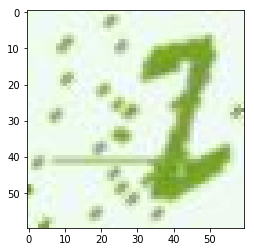

In [5]:
perm = np.random.permutation(CLASS_NUM*250)
ts = data[perm,:,:,:]
y = labels.iloc[perm]
print(y.iloc[0].loc[y.iloc[0]==1])
plt.imshow(array_to_img(ts[0,:,:,:]))
y = y.values[:,1:]

### Model, z którego będziemy korzystać

In [7]:
model = Sequential()

# 1
model.add(Conv2D(16, (3,3), strides=(1,1), padding='same', use_bias=False, input_shape=INPUT_SHAPE))
#model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 2
model.add(Conv2D(32, (3,3), strides=(1,1), padding='same', use_bias=False))
#model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 3
model.add(Conv2D(64, (3,3), strides=(1,1), padding='same', use_bias=False))
#model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# 4
model.add(Conv2D(128, (3,3), strides=(1,1), padding='same', use_bias=False))
#model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1,1), padding='same'))

# 5
model.add(Conv2D(256, (3,3), strides=(1,1), padding='same', use_bias=False))
#model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))

# 6
model.add(Conv2D(256, (3,3), strides=(1,1), padding='same', use_bias=False))
#model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))

# 7
model.add(Conv2D(CLASS_NUM, (8, 8), strides=(1, 1), kernel_initializer='he_normal'))
model.add(Activation('softmax'))
model.add(Reshape((CLASS_NUM,)))

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
sgd = SGD(lr=0.001, decay=0.0005, momentum=0.9)
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
adamax = keras.optimizers.Adamax(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.001)

model.compile(loss="categorical_crossentropy",
              optimizer=adamax, metrics=["accuracy"])

filepath="../checkpoints/pretrain-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

### Bardzo bardzo bardzo przetrenowany model, nie róbcie tego w domu

In [10]:
model.fit(ts, y, epochs=160, batch_size=60, shuffle = True, validation_split=0.2, callbacks=callbacks_list)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 12400 samples, validate on 3100 samples
Epoch 1/160
12400/12400 [==============================] - 127s 10ms/step - loss: 4.1312 - acc: 0.0161 - val_loss: 4.1276 - val_acc: 0.0119

Epoch 00001: val_acc improved from -inf to 0.01194, saving model to ../checkpoints/pretrain-improvement-01-0.01.hdf5
Epoch 2/160
12400/12400 [==============================] - 71s 6ms/step - loss: 4.1265 - acc: 0.0175 - val_loss: 4.1260 - val_acc: 0.0223

Epoch 00002: val_acc improved from 0.01194 to 0.02226, saving model to ../checkpoints/pretrain-improvement-02-0.02.hdf5
Epoch 3/160
12400/12400 [==============================] - 71s 6ms/step - loss: 4.0566 - acc: 0.0312 - val_loss: 3.8365 - val_acc: 0.0735

Epoch 00003: val_acc improved from 0.02226 to 0.07355, saving model to ../checkpoints/pretrain-improvement-03-0.07.hdf5
Epoch 4/160
12400/12400 [========================

12400/12400 [==============================] - 132s 11ms/step - loss: 0.3956 - acc: 0.8638 - val_loss: 0.5410 - val_acc: 0.8135

Epoch 00031: val_acc improved from 0.80871 to 0.81355, saving model to ../checkpoints/pretrain-improvement-31-0.81.hdf5
Epoch 32/160
12400/12400 [==============================] - 132s 11ms/step - loss: 0.3839 - acc: 0.8668 - val_loss: 0.5849 - val_acc: 0.7977

Epoch 00032: val_acc did not improve from 0.81355
Epoch 33/160
12400/12400 [==============================] - 133s 11ms/step - loss: 0.3810 - acc: 0.8656 - val_loss: 0.5289 - val_acc: 0.8090

Epoch 00033: val_acc did not improve from 0.81355
Epoch 34/160
12400/12400 [==============================] - 133s 11ms/step - loss: 0.3675 - acc: 0.8734 - val_loss: 0.5449 - val_acc: 0.8081

Epoch 00034: val_acc did not improve from 0.81355
Epoch 35/160
12400/12400 [==============================] - 132s 11ms/step - loss: 0.3603 - acc: 0.8735 - val_loss: 0.5411 - val_acc: 0.8119

Epoch 00035: val_acc did not impr


Epoch 00068: val_acc did not improve from 0.84742
Epoch 69/160
12400/12400 [==============================] - 71s 6ms/step - loss: 0.2108 - acc: 0.9288 - val_loss: 0.4546 - val_acc: 0.8423

Epoch 00069: val_acc did not improve from 0.84742
Epoch 70/160
12400/12400 [==============================] - 71s 6ms/step - loss: 0.2107 - acc: 0.9289 - val_loss: 0.4402 - val_acc: 0.8500

Epoch 00070: val_acc improved from 0.84742 to 0.85000, saving model to ../checkpoints/pretrain-improvement-70-0.85.hdf5
Epoch 71/160
12400/12400 [==============================] - 70s 6ms/step - loss: 0.2045 - acc: 0.9321 - val_loss: 0.4481 - val_acc: 0.8432

Epoch 00071: val_acc did not improve from 0.85000
Epoch 72/160
12400/12400 [==============================] - 70s 6ms/step - loss: 0.2055 - acc: 0.9307 - val_loss: 0.4432 - val_acc: 0.8484

Epoch 00072: val_acc did not improve from 0.85000
Epoch 73/160
12400/12400 [==============================] - 71s 6ms/step - loss: 0.2013 - acc: 0.9345 - val_loss: 0.446

12400/12400 [==============================] - 71s 6ms/step - loss: 0.1468 - acc: 0.9549 - val_loss: 0.4383 - val_acc: 0.8568

Epoch 00109: val_acc did not improve from 0.86290
Epoch 110/160
12400/12400 [==============================] - 71s 6ms/step - loss: 0.1470 - acc: 0.9544 - val_loss: 0.4353 - val_acc: 0.8584

Epoch 00110: val_acc did not improve from 0.86290
Epoch 111/160
12400/12400 [==============================] - 71s 6ms/step - loss: 0.1453 - acc: 0.9540 - val_loss: 0.4367 - val_acc: 0.8574

Epoch 00111: val_acc did not improve from 0.86290
Epoch 112/160
12400/12400 [==============================] - 71s 6ms/step - loss: 0.1432 - acc: 0.9547 - val_loss: 0.4413 - val_acc: 0.8539

Epoch 00112: val_acc did not improve from 0.86290
Epoch 113/160
12400/12400 [==============================] - 71s 6ms/step - loss: 0.1438 - acc: 0.9549 - val_loss: 0.4360 - val_acc: 0.8610

Epoch 00113: val_acc did not improve from 0.86290
Epoch 114/160
12400/12400 [==============================] 

12400/12400 [==============================] - 71s 6ms/step - loss: 0.1141 - acc: 0.9648 - val_loss: 0.4548 - val_acc: 0.8568

Epoch 00151: val_acc did not improve from 0.86516
Epoch 152/160
12400/12400 [==============================] - 70s 6ms/step - loss: 0.1133 - acc: 0.9656 - val_loss: 0.4465 - val_acc: 0.8606

Epoch 00152: val_acc did not improve from 0.86516
Epoch 153/160
12400/12400 [==============================] - 71s 6ms/step - loss: 0.1147 - acc: 0.9640 - val_loss: 0.4483 - val_acc: 0.8616

Epoch 00153: val_acc did not improve from 0.86516
Epoch 154/160
12400/12400 [==============================] - 71s 6ms/step - loss: 0.1129 - acc: 0.9654 - val_loss: 0.4553 - val_acc: 0.8587

Epoch 00154: val_acc did not improve from 0.86516
Epoch 155/160
12400/12400 [==============================] - 71s 6ms/step - loss: 0.1129 - acc: 0.9653 - val_loss: 0.4677 - val_acc: 0.8513

Epoch 00155: val_acc did not improve from 0.86516
Epoch 156/160
12400/12400 [==============================] 

In [11]:
print(model.predict(ts[:1,:,:,:]))
y[0,:]

[[1.43003543e-18 1.58722663e-20 1.92197895e-05 2.08068234e-17
  8.03848063e-23 3.65828092e-23 7.28129462e-25 2.89224186e-21
  2.36685523e-28 1.25216749e-24 0.00000000e+00 9.82686572e-27
  1.91473382e-11 4.52976534e-15 5.58007852e-18 0.00000000e+00
  4.61099325e-14 0.00000000e+00 4.56914367e-11 1.49332196e-34
  0.00000000e+00 4.48089741e-33 0.00000000e+00 0.00000000e+00
  1.33210655e-17 0.00000000e+00 1.27234792e-23 3.70998831e-36
  7.34399607e-12 7.07296009e-32 0.00000000e+00 0.00000000e+00
  0.00000000e+00 3.22337058e-34 0.00000000e+00 3.43376631e-03
  4.14116874e-13 0.00000000e+00 6.10624170e-07 0.00000000e+00
  1.76821992e-15 0.00000000e+00 2.05466317e-23 0.00000000e+00
  2.69745622e-24 8.96074536e-28 0.00000000e+00 3.35529479e-18
  0.00000000e+00 0.00000000e+00 3.42411836e-13 3.49078006e-32
  0.00000000e+00 4.30961737e-32 4.61232430e-09 4.55472425e-19
  8.41349687e-38 0.00000000e+00 0.00000000e+00 9.30140762e-34
  0.00000000e+00 9.96546447e-01]]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], dtype=int64)